# Bike Sharing Data Analysis
Author : Rahul_Patil@dell.com <br>
Date : 01/03/2022

Details : 
You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 


Steps :
1. Inital Analysis
    1. Read File
    2. Perform NULL analyis.
    2. Create Derived Variables
    3. Drop unwanted columns
2. Perform EDA
    1. Numerical Analysis (Scatter Plot + HeatMap)
    2. Categorical Analysis (Boxplot)
    3. Notedown important Inferences.
3. Model Building
    1. Train Test Split Data.
    2. Create Dummy Variables.
    3. Standardise Data.
    4. Use RFE to select top 15 variables
    5. Create model using top 15 variables.
    6. Drop columns having HIGH VIF and HIGH P values and then repeat till R^2 stabilises with minimum variables
    7. Build Model using SKLearn
    8. Perform Error/Residual Analysis
    9. Create Inferences
    

### Libraries

In [1]:
# Libraries that will be used
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [2]:
# Load the data
bike_df = pd.read_csv('day.csv')
bike_df.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# Shape of Data
bike_df.shape
print("Number of Rows : ",bike_df.shape[0])
print("Number of Columns : ",bike_df.shape[1])

Number of Rows :  730
Number of Columns :  16


### Null Value Analysis

In [4]:
# Null Value Analysis
bike_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [5]:
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Creating Derived Variables

In [6]:
# Creating Derived Variables.

# Instant column acts as "Days since start" and therefore dteday column can be dropped.
# Renaming column instant to "days_since_start."
bike_df.rename(columns={"instant":"days_since_start"}, inplace=True)

# Dropping column dteday
bike_df.drop(columns='dteday',axis=1, inplace=True)

# Creating a ratio of Casual to Registered users.
bike_df['ratio_of_casual_to_registered'] = bike_df.casual/bike_df.registered

# Dropping columns casual and registered as its a direct indicator of cnt columns
bike_df.drop(columns=['casual','registered'],axis=1, inplace=True)

### List of Generic Functions

In [7]:
# Renaming data of categorical variables.

def rename_season(x):
    if x==1:
        return 'spring'
    if x==2:
        return 'summer'
    if x==3:
        return 'fall'
    if x==4:
        return 'winter'



# Renaming data of categorical variables.

def rename_weather(x):
    if x==1:
        return 'clear'
    if x==2:
        return 'mist'
    if x==3:
        return 'light snow'
    if x==4:
        return 'heavy snow'

def standardize_data(bike_df, columns):
    scaler = MinMaxScaler()
    bike_df[columns] = scaler.fit_transform(bike_df[columns])
    bike_df.head(5)
    return bike_df[columns]


def fit_models(columns_to_consider):
    global current_aic, current_bic, X_train_lm
    model = sm.OLS(y_train, X_train_lm[columns_to_consider])
    result = model.fit()
    rsquare = result.rsquared
    adj_rsqured = result.rsquared_adj
    pvalues = result.pvalues
    pvalues_more_than_5 = pvalues[pvalues>0.05]
    aic = result.aic
    bic = result.bic
    print("Rsquared : ",result.rsquared)
    print("adjusted Rsquared : ",result.rsquared_adj)
    print("######################################################")
    print("pvalues more than 0,05")
    print("######################################################")
    print(pvalues_more_than_5)
    print("######################################################")
    print("vif more than 2")
    print("######################################################")
    vif = pd.DataFrame()
    vif["features"]= columns_to_consider
    vif['vif'] = [variance_inflation_factor(X_train_lm[columns_to_consider].values, i) for i in range(X_train_lm[columns_to_consider].shape[1])]

    print(vif[vif['vif']>2])
    if aic <= current_aic  or bic <= current_bic:
        print("Current Model is better than previous model")
        print(f"Current AIC : {current_aic}, Current BIC : {current_bic}")
        print(f"AIC : {aic}, BIC : {bic}")
        current_aic = aic
        current_bic = bic
    else:
        print("Current Model is worse than previous model")
        print(f"AIC : {aic}, BIC : {bic}")
        print(f"Current AIC : {current_aic}, Current BIC : {current_bic}")
        
# Replace Season data with its actual names since its not an ordinal data.
def get_dummies(dataframe, column_name, headers=None):
    dummy_data = pd.get_dummies(dataframe[column_name])
    if headers:
        dummy_data.columns = headers
    #Drop Season variable from orignal dataset
    #dataframe.drop(columns=[column_name],axis=1, inplace=True)

    #Append new season data to orignal bike dataframe

    dataframe = pd.concat([dataframe, dummy_data],axis=1)
    dataframe.head(5)
    return dataframe

In [8]:
bike_df.season = bike_df.season.apply(lambda x : rename_season(x))

bike_df.weathersit = bike_df.weathersit.apply(lambda x : rename_weather(x))

### Scatter plot of numeric variables.

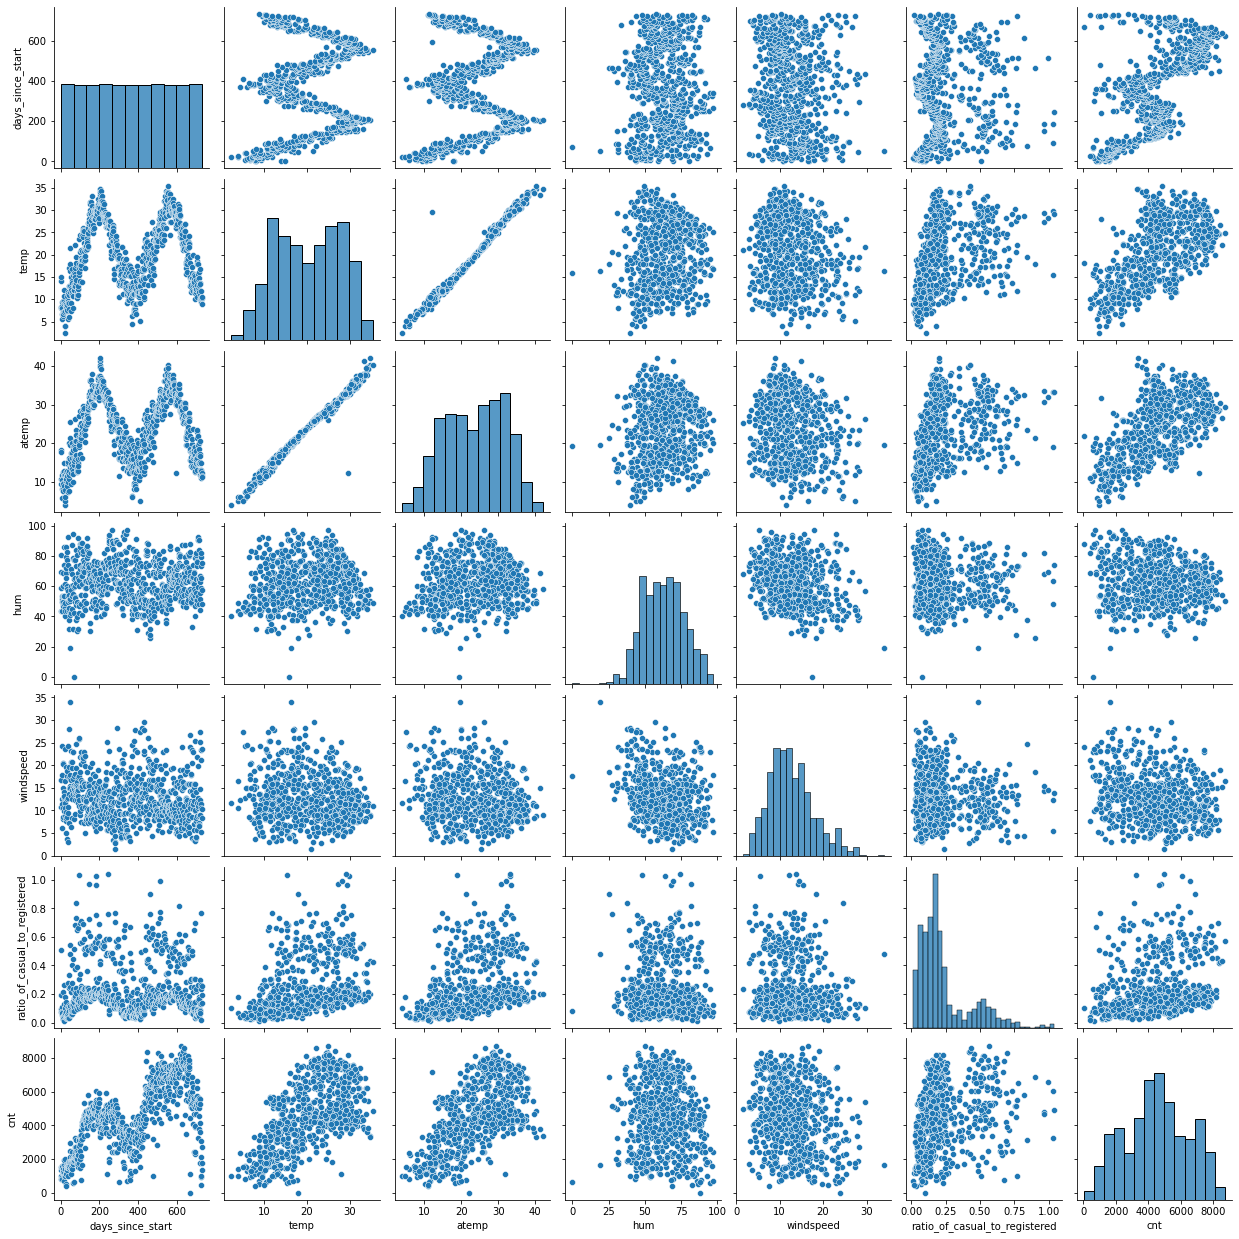

In [9]:
sns.pairplot(bike_df[['days_since_start','temp','atemp','hum','windspeed','ratio_of_casual_to_registered','cnt']],)

#### Inference
1. Initial Observation suggests that there is high correlation between atemp, temp and cnt
2. atemp and temp are highly correlated
3. As expected there is periodicity in temp column (Observing days_since_start_column)
4. There is some pattern between days_since_start and cnt column

### Heatmap for correlation

<AxesSubplot:>

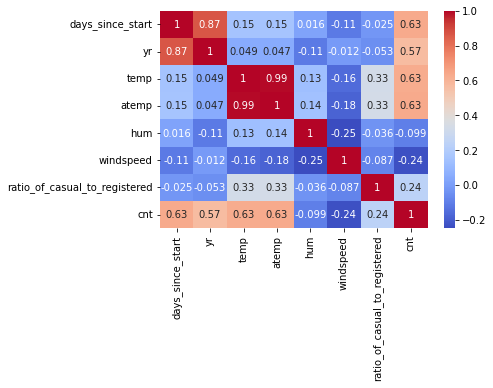

In [10]:
sns.heatmap(bike_df[['days_since_start','yr','temp','atemp','hum','windspeed','ratio_of_casual_to_registered','cnt']].corr(),cmap='coolwarm',annot=True)

#### Inference

1. The conclusion that we derived from scatter plots is quantified and validated

### Categorical Variable Analysis

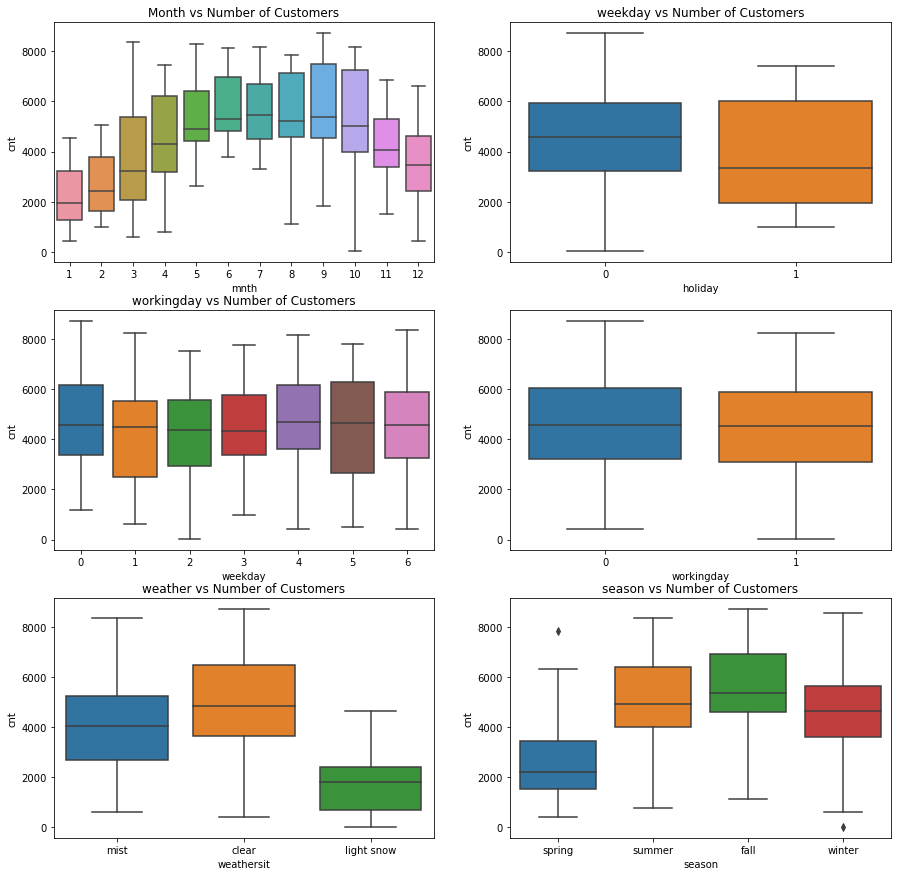

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15), )

ax[0][0].set_title('Month vs Number of Customers')
sns.boxplot(x=bike_df.mnth,ax=ax[0,0], y=bike_df.cnt)


ax[0][1].set_title('holiday vs Number of Customers')
sns.boxplot(x=bike_df.holiday,ax=ax[0,1], y=bike_df.cnt)

ax[0][1].set_title('weekday vs Number of Customers')
sns.boxplot(x=bike_df.weekday,ax=ax[1,0], y=bike_df.cnt)

ax[1][0].set_title('workingday vs Number of Customers')
sns.boxplot(x=bike_df.workingday,ax=ax[1,1], y=bike_df.cnt)

ax[2][0].set_title('weather vs Number of Customers')
sns.boxplot(x=bike_df.weathersit,ax=ax[2,0], y=bike_df.cnt)

ax[2][1].set_title('season vs Number of Customers')
sns.boxplot(x=bike_df.season,ax=ax[2,1], y=bike_df.cnt)

plt.show()

#### Inference
1. Fall Season has the highest number of customers as opposed to spring having the lowest.
2. During light snow the number of customers decreases drastically.
3. Months 5-10 see a high number of Customers.

### Categorical Data to Numerical Data

In [12]:
# Creating Dummy variables for columns month, season, and weather.
month_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
bike_df = get_dummies(bike_df, 'mnth',headers=month_columns)
bike_df = get_dummies(bike_df, 'season')
bike_df = get_dummies(bike_df, 'weathersit')

bike_df.head()

,days_since_start,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,...,Oct,Nov,Dec,fall,spring,summer,winter,clear,light snow,mist
0,1,spring,0,1,0,1,1,mist,14.110847,18.18125,...,0,0,0,0,1,0,0,0,0,1
1,2,spring,0,1,0,2,1,mist,14.902598,17.68695,...,0,0,0,0,1,0,0,0,0,1
2,3,spring,0,1,0,3,1,clear,8.050924,9.47025,...,0,0,0,0,1,0,0,1,0,0
3,4,spring,0,1,0,4,1,clear,8.200000,10.60610,...,0,0,0,0,1,0,0,1,0,0
4,5,spring,0,1,0,5,1,clear,9.305237,11.46350,...,0,0,0,0,1,0,0,1,0,0


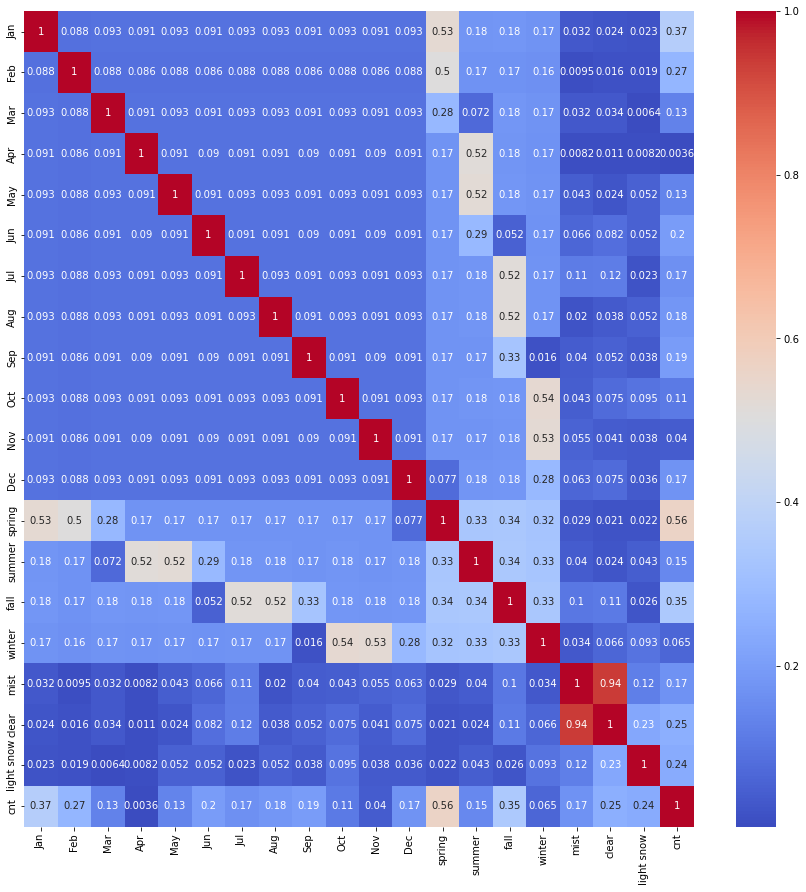

In [13]:
cat_columns = month_columns+['spring','summer','fall','winter','mist','clear','light snow','cnt']

plt.figure(figsize=(15,15))

sns.heatmap(abs(bike_df[cat_columns].corr()),cmap='coolwarm', annot=True,center=0.5)
plt.show()

#### Inference

1. As confirmed by heatmap. Fall and Spring seasons are very good indicators
2. seasons and months are correlated, therefore we must bear caution when including both in models

### Numerical Variable Analysis

Text(0.5, 1.0, 'Count of Customers vs time since start')

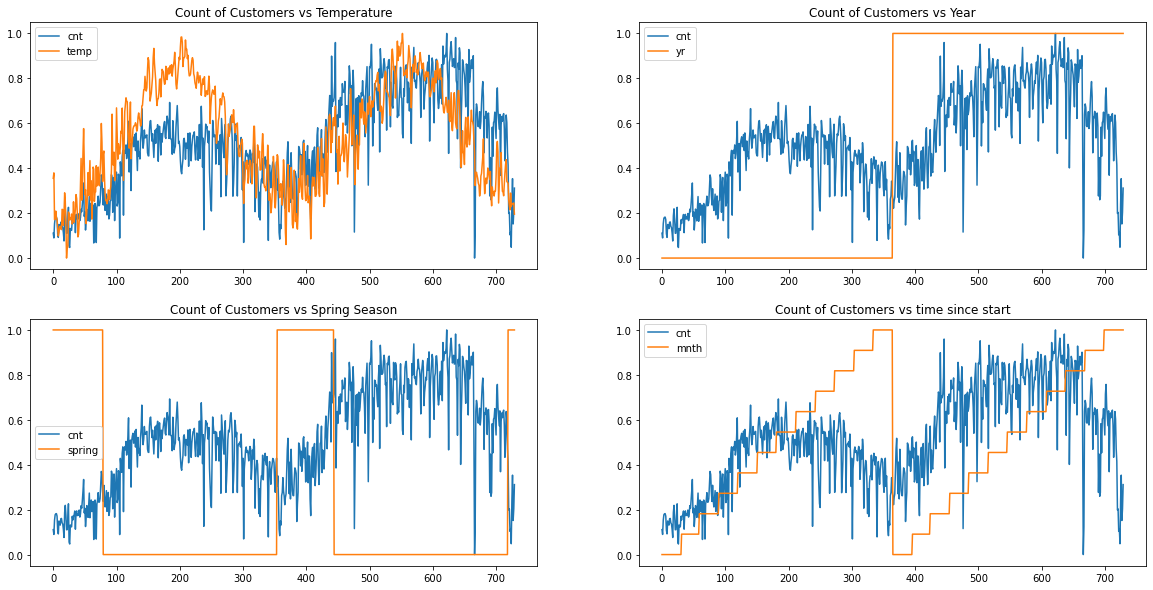

In [14]:

scaled_df = standardize_data(bike_df,['temp','atemp','hum','windspeed','ratio_of_casual_to_registered','cnt','mnth','yr','spring'])

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2,2)

scaled_df.cnt.plot(ax=ax[0,0])
scaled_df.temp.plot(ax=ax[0,0])
ax[0,0].legend()
ax[0,0].set_title("Count of Customers vs Temperature")

scaled_df.cnt.plot(ax=ax[0,1])
scaled_df.yr.plot(ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("Count of Customers vs Year")


scaled_df.cnt.plot(ax=ax[1,0])
scaled_df.spring.plot(ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title("Count of Customers vs Spring Season")

scaled_df.cnt.plot(ax=ax[1,1])
scaled_df.mnth.plot(ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title("Count of Customers vs time since start")

#### Inference

1. There is a very high overlap between temperature and customers.
2. Whenever Spring Season starts there is a dip in customers

In [15]:
### Finding columns with the highest intercorelation

high_corr = []
corr_data = bike_df.drop(['cnt'],axis=1).corr()
for index, data in corr_data.iterrows():
    for dep_column, row in data.iteritems():
        if row > 0.5:
            if index!=dep_column:
                if (dep_column, index, row) not in high_corr:
                    high_corr.append((index, dep_column, row))
high_corr = pd.DataFrame(data=high_corr, columns=['X','Y','corr_value'])
high_corr = high_corr.drop_duplicates().sort_values(by=['corr_value'], ascending=False)
high_corr

,X,Y,corr_value
2,temp,atemp,0.991696
0,days_since_start,yr,0.866026
1,mnth,winter,0.686895
3,temp,fall,0.678283
4,atemp,fall,0.655757
11,Oct,winter,0.536497
5,Jan,spring,0.532541
12,Nov,winter,0.526984
8,May,summer,0.524801
9,Jul,fall,0.517283


### Inference
1. air temp and temp are highly correlated
2. during fall both atemp and temp are less
3. Months and Seasons are related

## Building Model

### Creating Derived Columns

In [16]:
#Reading Data
bike_df = pd.read_csv('day.csv')


# Dropping column dteday
bike_df.drop(columns='dteday',axis=1, inplace=True)

#Creating a ratio of Casual to Registered users.
bike_df['ratio_of_casual_to_registered'] = bike_df.casual/bike_df.registered

# Dropping columns casual and registered as its a direct indicator of cnt columns
bike_df.drop(columns=['casual','registered'],axis=1, inplace=True)

### Processing Categorical Data.

In [17]:

#Processing Weather Data.
bike_df.weathersit = bike_df.weathersit.apply(lambda x : rename_weather(x))
bike_df = get_dummies(bike_df, 'weathersit')

#Processing Season Data.
bike_df.season = bike_df.season.apply(lambda x : rename_season(x))
bike_df = get_dummies(bike_df, 'season')

#Processing Monthly Data.
month_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
bike_df = get_dummies(bike_df, 'mnth',headers=month_columns)

#Processing Weekend and Weekday data.
bike_df.weekday = bike_df.weekday.apply(lambda x : 1 if x>0 and x<=5 else 0)
bike_df = get_dummies(bike_df, 'weekday',['Weekday','Weekend'])
bike_df.drop(columns=['Weekend'],axis=1, inplace=True)


#Dropping Transformed Columns
columns_to_drop = ['mnth','weathersit','season','weekday','instant']
bike_df.drop(columns=columns_to_drop, axis=1, inplace=True)
bike_df.head()

#Splitting X and Y
y=bike_df['cnt']
X=bike_df.drop('cnt',axis=1)

### Train Test Split

In [18]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"X_train, {X_train.shape}")
print(f"X_test, {X_test.shape}")
print(f"y_train, {y_train.shape}")
print(f"y_test, {y_test.shape}")

X_train, (511, 28)
X_test, (219, 28)
y_train, (511,)
y_test, (219,)


### Min Max Scaling Train Data

In [19]:
scaler = MinMaxScaler()
scaler.fit(X_train[['temp','atemp','hum','windspeed']])
X_train[['temp','atemp','hum','windspeed']] = scaler.transform(X_train[['temp','atemp','hum','windspeed']])
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,ratio_of_casual_to_registered,clear,light snow,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Weekday
683,1,0,1,0.327133,0.322150,0.639330,0.327101,0.062439,0,0,...,0,0,0,0,0,0,0,1,0,0
645,1,1,0,0.403972,0.404998,0.731215,0.419004,0.189835,0,0,...,0,0,0,0,0,0,1,0,0,0
163,0,0,1,0.717562,0.685963,0.509660,0.708724,0.207602,1,0,...,0,0,1,0,0,0,0,0,0,0
360,0,0,1,0.331287,0.326273,0.785745,0.415925,0.097262,0,0,...,0,0,0,0,0,0,0,0,1,0
640,1,0,1,0.745598,0.682653,0.817947,0.110593,0.106371,0,0,...,0,0,0,0,0,0,1,0,0,0


### Using RFE to get top 15 features from dataset

In [20]:
# Creating LM Model
lm = LinearRegression()
lm.fit(X_train,y_train)

#Traing RFE Model
rfe  = RFE(lm, n_features_to_select=15)
rfe.fit(X_train, y_train)

# Creating rank_df dataframe that holds best features data.
rank_df  = pd.DataFrame()
rank_df['columns'] = X_train.columns
rank_df['rank'] = rfe.ranking_
rank_df['support'] = rfe.support_
rank_df
columns_to_consider = rank_df[rank_df.support==True]['columns'].values.tolist()
X_train[columns_to_consider].head()

,yr,holiday,temp,atemp,hum,windspeed,clear,light snow,spring,winter,Jun,Jul,Aug,Nov,Dec
683,1,0,0.327133,0.322150,0.639330,0.327101,0,0,0,1,0,0,0,1,0
645,1,1,0.403972,0.404998,0.731215,0.419004,0,0,0,1,0,0,0,0,0
163,0,0,0.717562,0.685963,0.509660,0.708724,1,0,0,0,1,0,0,0,0
360,0,0,0.331287,0.326273,0.785745,0.415925,0,0,1,0,0,0,0,0,1
640,1,0,0.745598,0.682653,0.817947,0.110593,0,0,0,1,0,0,0,0,0


### Manual Elimination of features from Model

#### Model 1

In [21]:
# Building Initial Model using temp as the main attribute
X_train_lm = sm.add_constant(X_train[columns_to_consider])
columns_to_consider = X_train_lm.columns.values.tolist()
model = sm.OLS(y_train, X_train_lm)
result = model.fit()
current_aic = result.aic
current_bic = result.bic
print(result.summary())
print("######################################################")
vif = pd.DataFrame()
vif["features"]= columns_to_consider
vif['vif'] = [variance_inflation_factor(X_train_lm[columns_to_consider].values, i) for i in range(X_train_lm[columns_to_consider].shape[1])]

print(vif)
    
    

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     171.8
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          4.22e-185
Time:                        01:01:06   Log-Likelihood:                -4126.3
No. Observations:                 511   AIC:                             8285.
Df Residuals:                     495   BIC:                             8352.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2754.1013    339.894      8.103      0.0

In [22]:
for i in columns_to_consider:
    print(f'"{i}"',end=',')

"const","yr","holiday","temp","atemp","hum","windspeed","clear","light snow","spring","winter","Jun","Jul","Aug","Nov","Dec",

#### Model 2 
1) Removing atemp for columns due to high vif value

In [23]:
columns_to_consider = ["const","yr","holiday","temp","hum","windspeed","clear","light snow","spring","winter","Jun","Jul","Aug","Nov","Dec"]
fit_models(columns_to_consider)

Rsquared :  0.8387519190277135
adjusted Rsquared :  0.8342005619034958
######################################################
pvalues more than 0,05
######################################################
Series([], dtype: float64)
######################################################
vif more than 2
######################################################
  features        vif
0    const  93.491821
3     temp   4.518330
8   spring   2.860060
9   winter   2.284983
Current Model is better than previous model
Current AIC : 8284.53986996524, Current BIC : 8352.321783408499
AIC : 8282.844149482076, BIC : 8346.389693335132


#### Model 3
1) Removing temp from columns due to high vif

In [24]:
columns_to_consider = ["const","yr","holiday","hum","windspeed","clear","light snow","spring","winter","Jun","Jul","Aug","Nov","Dec"]
fit_models(columns_to_consider)

Rsquared :  0.7822738123159823
adjusted Rsquared :  0.7765787611290763
######################################################
pvalues more than 0,05
######################################################
hum    0.360447
Jul    0.272742
Aug    0.175625
dtype: float64
######################################################
vif more than 2
######################################################
  features        vif
0    const  79.202220
8   winter   2.196975
Current Model is worse than previous model
AIC : 8434.294485109254, BIC : 8493.603659372106
Current AIC : 8282.844149482076, Current BIC : 8346.389693335132


#### Model 4
Removing hum from data as its insignificant

In [25]:
columns_to_consider = ["const","yr","holiday","windspeed","Jun","Jul","Aug","Nov","Dec","spring","clear","light snow"]

fit_models(columns_to_consider)

Rsquared :  0.7792192627507224
adjusted Rsquared :  0.7743523527111592
######################################################
pvalues more than 0,05
######################################################
Jul    0.657151
Aug    0.477736
dtype: float64
######################################################
vif more than 2
######################################################
  features       vif
0    const  10.70989
Current Model is worse than previous model
AIC : 8437.413643259697, BIC : 8488.250078342142
Current AIC : 8282.844149482076, Current BIC : 8346.389693335132


#### Model 5:
Removing July from data as its insignificant

In [26]:
columns_to_consider = ["const","yr","holiday","windspeed","Jun","Aug","Nov","Dec","spring","clear","light snow"]

fit_models(columns_to_consider)

Rsquared :  0.7791319951710525
adjusted Rsquared :  0.7747146350744736
######################################################
pvalues more than 0,05
######################################################
Jun    0.053653
Aug    0.521165
dtype: float64
######################################################
vif more than 2
######################################################
  features        vif
0    const  10.231681
Current Model is worse than previous model
AIC : 8435.615585344178, BIC : 8482.215650836419
Current AIC : 8282.844149482076, Current BIC : 8346.389693335132


#### Model 6:
Removing Aug from data as its insignificant

In [27]:
columns_to_consider = ["const","yr","holiday","windspeed","Jun","Nov","Dec","spring","clear","light snow"]

fit_models(columns_to_consider)

Rsquared :  0.7789499255452328
adjusted Rsquared :  0.7749789661238897
######################################################
pvalues more than 0,05
######################################################
Jun    0.063185
dtype: float64
######################################################
vif more than 2
######################################################
  features       vif
0    const  9.825619
Current Model is worse than previous model
AIC : 8434.036647927582, BIC : 8476.400343829619
Current AIC : 8282.844149482076, Current BIC : 8346.389693335132


#### Model 7:
Removing June from data as its insignificant

In [28]:
columns_to_consider = ["const","yr","holiday","windspeed","Nov","Dec","spring","clear","light snow"]

fit_models(columns_to_consider)

Rsquared :  0.7774201615798721
adjusted Rsquared :  0.773873072521384
######################################################
pvalues more than 0,05
######################################################
Series([], dtype: float64)
######################################################
vif more than 2
######################################################
  features       vif
0    const  9.607948
Current Model is worse than previous model
AIC : 8435.560812831662, BIC : 8473.688139143494
Current AIC : 8282.844149482076, Current BIC : 8346.389693335132


#### Model 8:
Removing July from data as its insignificant

In [29]:
columns_to_consider = ["const","yr","holiday","windspeed","Nov","Dec","spring","clear","light snow","temp"]

fit_models(columns_to_consider)

Rsquared :  0.8109425928359816
adjusted Rsquared :  0.8075463519887238
######################################################
pvalues more than 0,05
######################################################
Series([], dtype: float64)
######################################################
vif more than 2
######################################################
  features        vif
0    const  33.062135
6   spring   2.176684
9     temp   2.503749
Current Model is worse than previous model
AIC : 8354.147650641895, BIC : 8396.511346543932
Current AIC : 8282.844149482076, Current BIC : 8346.389693335132


#### Model 9:
Adding temp column as we know it has a significant relation

In [30]:
columns_to_consider = ["const","yr","holiday","windspeed","Nov","Dec","spring","clear","light snow",'temp']

fit_models(columns_to_consider)

Rsquared :  0.8109425928359816
adjusted Rsquared :  0.8075463519887238
######################################################
pvalues more than 0,05
######################################################
Series([], dtype: float64)
######################################################
vif more than 2
######################################################
  features        vif
0    const  33.062135
6   spring   2.176684
9     temp   2.503749
Current Model is worse than previous model
AIC : 8354.147650641895, BIC : 8396.511346543932
Current AIC : 8282.844149482076, Current BIC : 8346.389693335132


###  Final Model

In [31]:
# Building Initial Model using temp as the main attribute
columns_to_consider = ["yr","holiday","windspeed","Nov","Dec","spring","clear","light snow",'temp']
X_train = sm.add_constant(X_train[columns_to_consider])
model = sm.OLS(y_train, X_train)
result = model.fit()
print(result.summary())
print("######################################################")
vif = pd.DataFrame()
vif["features"]= X_train.columns
vif['vif'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif)
    
    

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     238.8
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          6.51e-175
Time:                        01:01:07   Log-Likelihood:                -4167.1
No. Observations:                 511   AIC:                             8354.
Df Residuals:                     501   BIC:                             8397.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2705.2423    216.306     12.507      0.0

###  Transforming Test Data/Preparing for evaluation

In [32]:
lm  = LinearRegression()
columns_to_consider = ["yr","holiday","windspeed","Nov","Dec","spring","clear","light snow",'temp']

#scaler = MinMaxScaler()
X_test[['temp','atemp','hum','windspeed']] = scaler.transform(X_test[['temp','atemp','hum','windspeed']])
X_test = X_test[columns_to_consider]
X_test.head()

,yr,holiday,windspeed,Nov,Dec,spring,clear,light snow,temp
468,1,0,0.422104,0,0,0,1,0,0.543115
148,0,0,0.479765,0,0,0,1,0,0.758058
302,0,0,0.386287,0,0,0,1,0,0.324018
355,0,0,0.062325,0,1,1,0,0,0.453814
515,1,0,0.433030,0,0,0,1,0,0.773634


### Evaluation on Test Data

In [33]:
lm = LinearRegression()
lm.fit(X_train[columns_to_consider], y_train)
prediction = lm.predict(X_test)
r2_score(y_test,prediction)

0.8094631370787212

## Train r2 score : 81.1, Test r2 score : 80.9

### Testing Distribution of Residuals

C:\Users\Rahul_Patil2\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


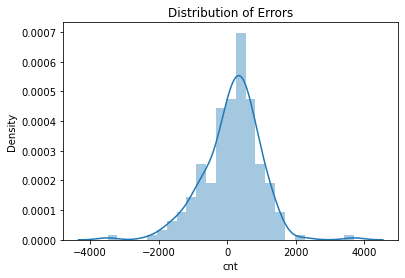

In [34]:
sns.distplot(y_test-prediction, )
plt.title("Distribution of Errors")
plt.show()

### Testing Randomness of Error

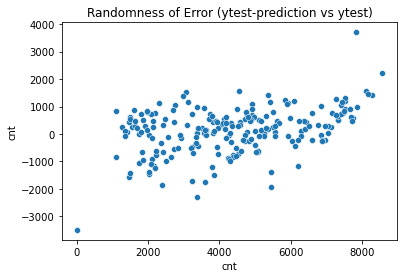

In [35]:
sns.scatterplot(x=y_test, y=y_test-prediction)
plt.title("Randomness of Error (ytest-prediction vs ytest)")
plt.show()

### Actual vs Predicted

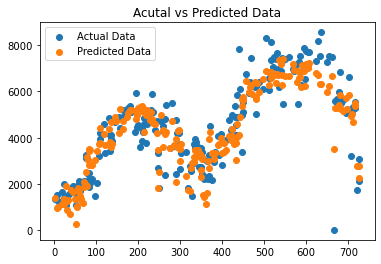

In [36]:
plt.scatter(y=y_test, x=y_test.index, label='Actual Data')
plt.scatter(y=prediction, x=y_test.index, label='Predicted Data')
plt.title("Acutal vs Predicted Data")
plt.legend()
plt.show()

### Testing MultiCollinearity

<AxesSubplot:>

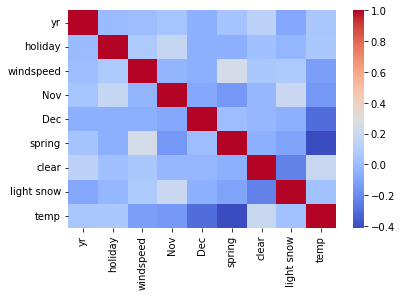

In [37]:
sns.heatmap(X_test.corr(),cmap='coolwarm', robust=True)

### Coefficient

In [38]:
out = []
for column, coeff in zip(X_test.columns,lm.coef_):
    out.append((column, coeff))
pd.DataFrame(out, columns=['column','coeff'])

,column,coeff
0,yr,2030.274329
1,holiday,-649.674817
2,windspeed,-1039.563607
3,Nov,-383.968884
4,Dec,-441.205533
5,spring,-1776.769018
6,clear,643.051218
7,light snow,-1516.747227
8,temp,2471.425914


## Inferences

1. Train R2 Score : 81.1
2. Train Adj R2 Score : 80.4
3. Test R2 Score : 80.9
4. Number of features : 9
5. Conclusion
    1. According to trends year wise, we should have more customers the next year.
    2. As the temp increases, the number of customer also increases.
    3. Spring is not a good season to attract customers.
    4. Light Snow and Rain adversely affect number of customers.
    5. the clearer the weather the more the customers.
    6. Year end is not a good time for bike sharing